In [21]:
# File specific for the LSTN_FDST_DATASET.
# We only annotate 3 images per video because otherwise we will have 250GB of data.
# Perhaps it's better to just generate the ground-truth 'on the fly' when training a model.

import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import time
from datetime import datetime
import torch
from torch.utils.data import DataLoader


%matplotlib inline

In [8]:
# Maybe windows specific
LSTN_base_path = os.path.join("D:\\", "OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\LSTN_FDST_DATASET") 

LSTN_train_base_path = os.path.join(LSTN_base_path, "train")
LSTN_test_base_path = os.path.join(LSTN_base_path, "test")

In [97]:
import numpy as np
import os
import random
from scipy import io as sio
import sys
import torch
from torch.utils import data
from PIL import Image, ImageOps

import pandas as pd

# from config import cfg

def region_to_coords(region):
    attributes = region['shape_attributes']
    x = attributes['x']
    y = attributes['y']
    width = attributes['width']
    height = attributes['height']
    x += round(width / 2)
    y += round(height / 2)
    return x, y

def generate_density(img, regions, sigma):
    """ Given an image, its corresponding ground-truth annotated file, and a standard deviation, creates the ground-truth density map.
        img: The image corresponding to the ground-truth annotations
        mat: The coordinates of the annotations.
        sigma: A constant sigma used for the gaussian filter."""
    
    w, h = img.size
    k = np.zeros((h, w))
    
    for region in regions:
        x, y = region_to_coords(region)
        if x < w and y < h:
            k[y, x] = 1  # Note the order of x and y here. Height is stored in first dimension
        else:
            print("This should never happen!")  # This would mean a head is annotated outside the image.
    
    density = scipy.ndimage.filters.gaussian_filter(k, sigma, mode='constant')  
    return density

class LSTN_FDST(data.Dataset):
    def __init__(self, data_path, mode, main_transform=None, img_transform=None, gt_transform=None):
        self.data_path = data_path
        self.mode = mode
        self.videos = [vid for vid in os.listdir(self.data_path)]
        
        # full imgs paths are our data files.
        self.data_files = []
        for vid in self.videos:
            vid_path = os.path.join(self.data_path, vid)
            imgs = [os.path.join(vid_path, img) for img in os.listdir(vid_path) 
                    if  img[-4:] == '.jpg' and img[0] != '.']  # Is a jpg file and not a 4kb mac hidden item
            self.data_files.extend(imgs)
        
        self.num_samples = len(self.data_files) 
        self.main_transform = main_transform  
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        print(self.num_samples)
    
    def __getitem__(self, index):
        fname = self.data_files[index]
        img, den = self.read_image_and_gt(fname)      
        if self.main_transform is not None:
            img, den = self.main_transform(img,den) 
        if self.img_transform is not None:
            img = self.img_transform(img)         
        if self.gt_transform is not None:
            den = self.gt_transform(den)              
#         return img, den
        return torch.from_numpy(np.array(img)), torch.from_numpy(np.array(den))

    def __len__(self):
        return self.num_samples

    def read_image_and_gt(self,fname):
        img_path = fname
        gt = fname.replace('.jpg', '.json')
        
        img = Image.open(img_path)
        if img.mode == 'L':
            img = img.convert('RGB')


        with open(gt) as f:
            gt = json.load(f)
        
        key = list(gt.keys())[0]
        regions = list(gt[key]['regions'])

        den = generate_density(img, regions, 5)
  
        den = den.astype(np.float32, copy=False)    
        den = Image.fromarray(den)  
        return img, den    

    def get_num_samples(self):
        return self.num_samples       
            
        

In [98]:
my_dataset = LSTN_FDST(LSTN_test_base_path, 'test')
train_loader = DataLoader(my_dataset, batch_size=1, num_workers=0, shuffle=True, drop_last=True)

6000


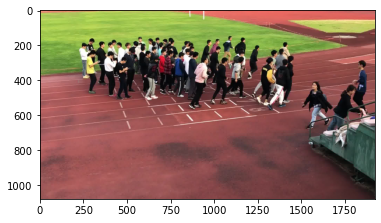

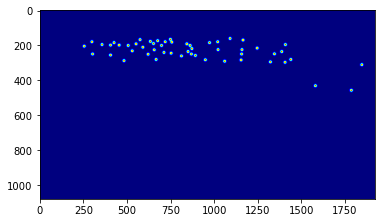

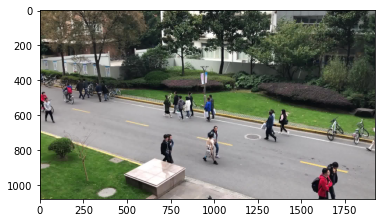

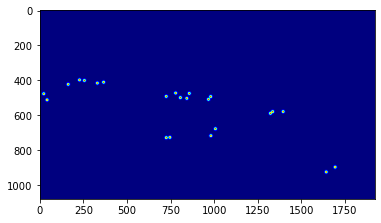

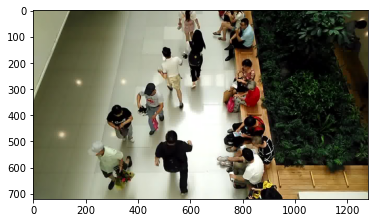

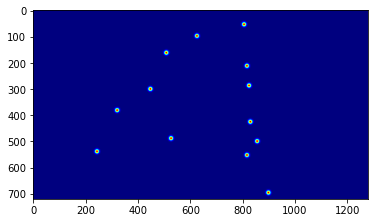

In [147]:
for i, data in enumerate(train_loader):
    img, gt = data
    
    img = np.array(img.squeeze())
    gt = np.array(gt.squeeze())
    
    plt.figure()
    plt.imshow(img)
    
    plt.figure()
    plt.imshow(gt,cmap=CM.jet)

#     if np.shape(img) != (1080, 1920, 3):
#         break

In [148]:
pil_img = Image.fromarray(img)

In [149]:
h, w, _ = np.shape(img)
print(np.shape(img))
factor = 720 / w
new_h = round(factor * h)
new_w = round(factor * w)
print(new_h, new_w)

(720, 1280, 3)
405 720


In [150]:
pil_img.show()

In [151]:
pil_img = pil_img.resize((new_w, new_h))

In [152]:
pil_img.show()